In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 32°C,   0 % |  4333 / 81920 MB | gpatters(4324M)
  [1] NVIDIA A100 80GB PCIe | 27°C,   0 % |     0 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 28°C,   0 % |     0 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "."
labels = pd.read_csv(base_folder + "/labels.csv")
labels

,R0,surv_mult,rep,bias,N_avg,N_final,n,npops,nsibs
0,8.52,0.99,1,1.0,1937.047619,1602,2000,556,1511
1,8.52,0.99,1,15.5,1937.047619,1602,2050,679,1883
2,8.52,0.99,1,30.0,1937.047619,1602,2050,705,2033
3,8.52,0.99,2,1.0,2631.428571,2390,2000,406,1262
4,8.52,0.99,2,15.5,2631.428571,2390,2050,510,1520
...,...,...,...,...,...,...,...,...,...
22945,9.90,1.01,49,15.5,26395.000000,29341,2050,73,179
22946,9.90,1.01,49,30.0,26395.000000,29341,2050,75,160
22947,9.90,1.01,50,1.0,25813.714286,28081,2000,48,129
22948,9.90,1.01,50,15.5,25813.714286,28081,2050,59,168


./bearded_seal_images/spaghetti_pops_8.52_0.99_1_1.0_2000.png
./bearded_seal_images/spaghetti_sibs_8.52_0.99_1_1.0_2000.png
./bearded_seal_images/sampling_intensity_8.52_0.99_1_1.0_2000.png


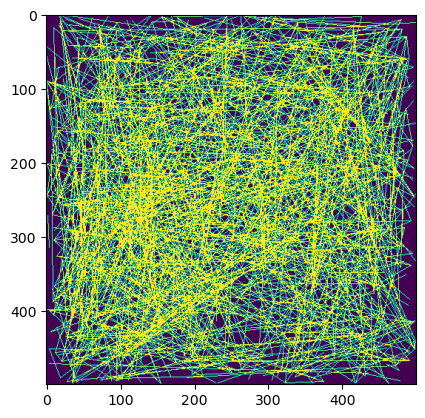

In [5]:
idx = 0
row = labels.iloc[idx,]
R0 = row.loc['R0']
surv_mult = row.loc['surv_mult']
rep = int(row.loc['rep'])
bias = row.loc['bias']
n = int(row.loc['n'])
pops_path = f'{base_folder}/bearded_seal_images/spaghetti_pops_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
print(pops_path)
pops = read_image(pops_path)
sibs_path = f'{base_folder}/bearded_seal_images/spaghetti_sibs_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
print(sibs_path)
sibs = read_image(sibs_path)
intensity_path = f'{base_folder}/bearded_seal_images/sampling_intensity_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
print(intensity_path)
intensity = read_image(intensity_path)
plt.imshow(sibs[0])

In [6]:
print(pops.size())
print(sibs.size())
print(intensity.size())
images = torch.cat((pops, sibs, intensity), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([3, 500, 500])


In [19]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        surv_mult = row.loc['surv_mult']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_pops_path = f'{self.base_folder}/bearded_seal_images/spaghetti_pops_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        spaghetti_pops = read_image(spaghetti_pops_path)
        spaghetti_sibs_path = f'{self.base_folder}/bearded_seal_images/spaghetti_sibs_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        spaghetti_sibs = read_image(spaghetti_sibs_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/sampling_intensity_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity), 0).float()
        label = torch.tensor([self.labels['N_final'].iloc[idx]]).float()
        return input_tensor, label, surv_mult, bias
    
kin_dataset = KinDataset(".", "labels.csv")

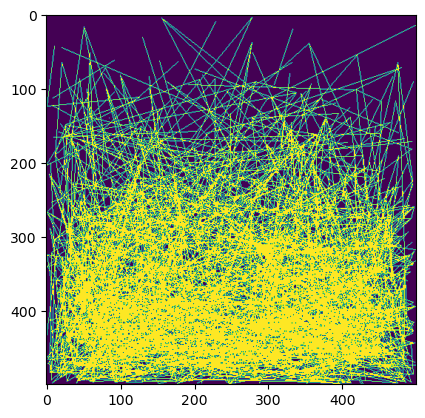

In [8]:
plt.imshow(kin_dataset[2][0][0])
plt.imshow(kin_dataset[2][0][1])
#plt.imshow(kin_dataset[2][0][2])

In [9]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [20]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

11475
5738
5737


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [12]:
loss_fn = nn.MSELoss(reduction='mean')

In [13]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [14]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 12683815.5113 val_loss: 2310023.8388
Epoch 2 loss: 2394044.0290 val_loss: 2491424.5673
Epoch 3 loss: 2375892.9668 val_loss: 2903231.4672
Epoch 4 loss: 1702727.5753 val_loss: 2061181.0277
Epoch 5 loss: 1525099.1093 val_loss: 2160241.9900
Epoch 6 loss: 1125897.4038 val_loss: 2448783.5579
Epoch 7 loss: 965861.5529 val_loss: 3359846.6807
Epoch 8 loss: 879144.9512 val_loss: 2167340.2035
Epoch 9 loss: 617046.4725 val_loss: 2325985.0751
Epoch 10 loss: 501641.4698 val_loss: 2429591.5505
Epoch 11 loss: 476636.4887 val_loss: 2307245.7733
Epoch 12 loss: 458707.7156 val_loss: 2356574.8106
Epoch 13 loss: 417343.9333 val_loss: 2254220.3554
Epoch 14 loss: 349070.3286 val_loss: 2617088.4964
Epoch 15 loss: 369689.5209 val_loss: 2338403.7188
Epoch 16 loss: 361236.7791 val_loss: 2289144.1386
Epoch 17 loss: 339089.0233 val_loss: 2444568.3451
Epoch 18 loss: 375030.0208 val_loss: 2623709.4861
Epoch 19 loss: 433070.7585 val_loss: 2464947.1466
Epoch 20 loss: 368990.2010 val_loss: 2336879.3366


In [15]:
#Save model
PATH = "model_pops_sibs_popsize_change.pt"
torch.save(model.state_dict(), PATH)

In [16]:
# Load model
PATH = "model_pops_sibs_popsize_change.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

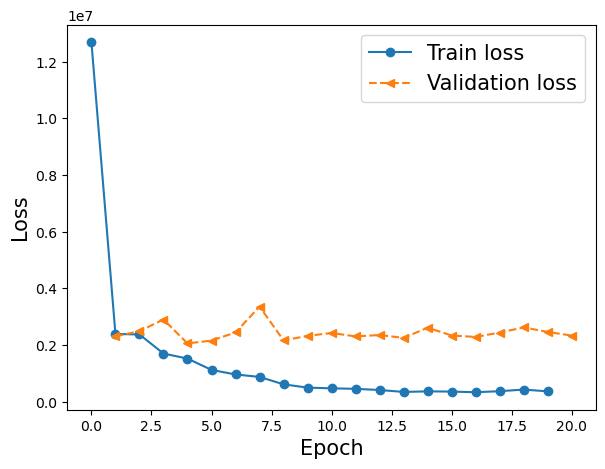

In [16]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

## Record bias when testing
- Random simulations have maximum sampling intensity of 8
- Bias 15.5 have max intensity 132
- Bias 30 have max intensity 255

In [21]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_surv_mult = np.empty(len(test_kin))
test_bias = np.empty(len(test_kin))

# If you add channels to the input, you need to change how the bias is calculated so that its using the correct image
with torch.no_grad():
    for i, (test_input, test_output, surv_mult, bias) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_bias[i] = bias
        test_surv_mult[i] = surv_mult

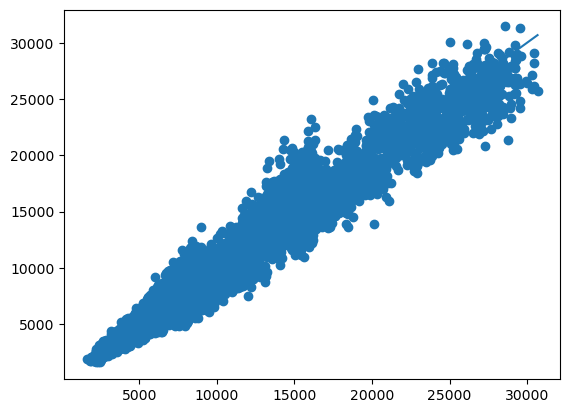

In [22]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [23]:
# Write test results to file
results = {'true_N_final': test_truth, 'bearded_nn_pred': test_pred, 'bias': test_bias, 'surv_mult': test_surv_mult}
df = pd.DataFrame(data=results)
df.to_csv("../bearded_seals_nn_results/model_pops_sibs_popsize_change.csv", index = False)

random reps 628
medium bias reps 628
high bias reps 628


Text(0.5, 1.0, 'High bias')

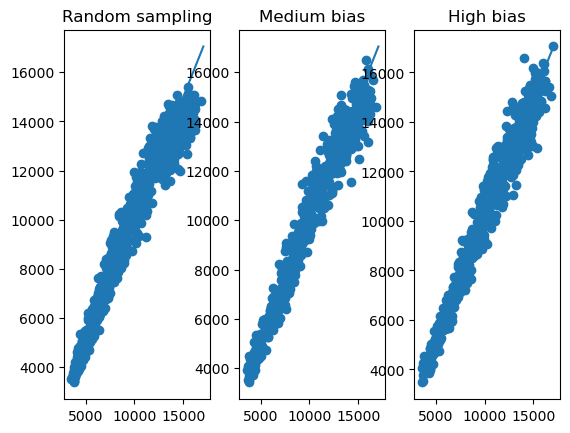

In [39]:
# Divide test data by sampling plan and plot separately
random = test_bias == 1
medium_bias = test_bias == 16.5
high_bias = test_bias == 31.875
print("random reps", sum(random))
print("medium bias reps", sum(random))
print("high bias reps", sum(random))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(test_truth[random], test_pred[random])
ax1.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax1.set_title("Random sampling")
ax2.scatter(test_truth[medium_bias], test_pred[medium_bias])
ax2.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax2.set_title("Medium bias")
ax3.scatter(test_truth[high_bias], test_pred[high_bias])
ax3.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax3.set_title("High bias")
